# PINN for Three-Phase Cahn-Hilliard
Initial notes and experiments.

In [24]:
!git clone https://github.com/Liam-48/pinn-cahn-hilliard.git
!ls pinn-cahn-hilliard/

fatal: destination path 'pinn-cahn-hilliard' already exists and is not an empty directory.
LICENSE  notebooks  README.md  src


In [25]:
import sys
sys.path.append('/content/pinn-cahn-hilliard/src')

In [26]:
import torch
import matplotlib.pyplot as plt

In [27]:
from pinn_model import PINN
from pinn_loss import pinn_loss
from utils import plot_slices

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Domain size values and parameters

In [29]:
gamma = 5
Nx, Ny, Nt = 16, 16, 4
Xmin, Xmax = 0, 128
Ymin, Ymax = 0, 128
Tmin, Tmax = 0, 10
times = [0.0, 5.0, 10.0]

In [30]:
torch.autograd.set_detect_anomaly(True)

In [31]:
x = torch.linspace(Xmin, Xmax, Nx)
y = torch.linspace(Ymin, Ymax, Ny)
t = torch.linspace(Tmin, Tmax, Nt)
X, Y, T = torch.meshgrid(x, y, t, indexing='ij')
coords = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1).to(device)
t_vals = T.reshape(-1, 1).to(device)

Initial conditions definitions

In [32]:
X0, Y0 = torch.meshgrid(x, y, indexing='ij')
coords_0 = torch.stack([X0.reshape(-1), Y0.reshape(-1)], dim=1).to(device)
dirichlet_samples = torch.distributions.Dirichlet(torch.tensor([10.0, 10.0, 10.0])).sample((Nx*Ny,))
c1_0 = dirichlet_samples[:, 0:1].to(device)
c2_0 = dirichlet_samples[:, 1:2].to(device)

Boundary conditions definitions

In [33]:
y_bc = torch.linspace(Ymin, Ymax, Ny)
x_bc = torch.linspace(Xmin, Xmax, Nx)
t_bc = torch.rand(Nx, 1) * (Tmax - Tmin)
top = torch.stack([x_bc, torch.full_like(x_bc, Ymin)], dim=1).reshape(-1, 2)
bottom = torch.stack([x_bc, torch.full_like(x_bc, Ymax)], dim=1).reshape(-1, 2)
left = torch.stack([torch.full_like(y_bc, Xmin), y_bc], dim=1).reshape(-1, 2)
right = torch.stack([torch.full_like(y_bc, Xmax), y_bc], dim=1).reshape(-1, 2)
coords_per_bc = torch.cat([top, bottom, left, right], dim=0).to(device)
t_per_bc = torch.cat([t_bc]*4, dim=0).to(device)

Mobility tensor

In [34]:
M = torch.tensor([[2.0, -1.0, -1.0],
                  [-1.0, 2.0, -1.0]], device=device)

In [35]:
model = PINN(in_dim=3, out_dim=2, hidden=128, layers=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

True initial condition grid for $c_1$

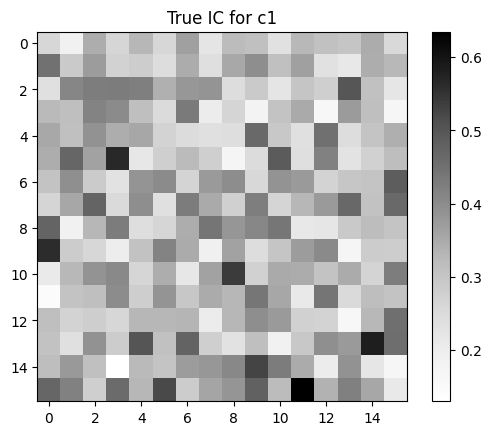

In [37]:
plt.imshow(c1_0.reshape(Nx, Ny).cpu(), cmap='Greys')
plt.title('True IC for c1')
plt.colorbar()
plt.show()

## Training loop

Epoch 0: Loss = 1.0887e+01


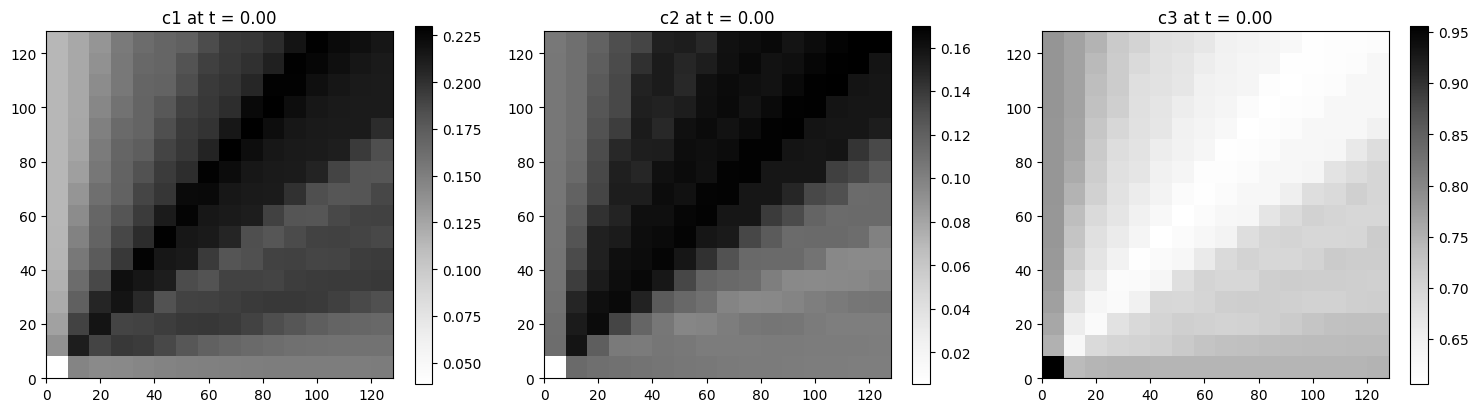

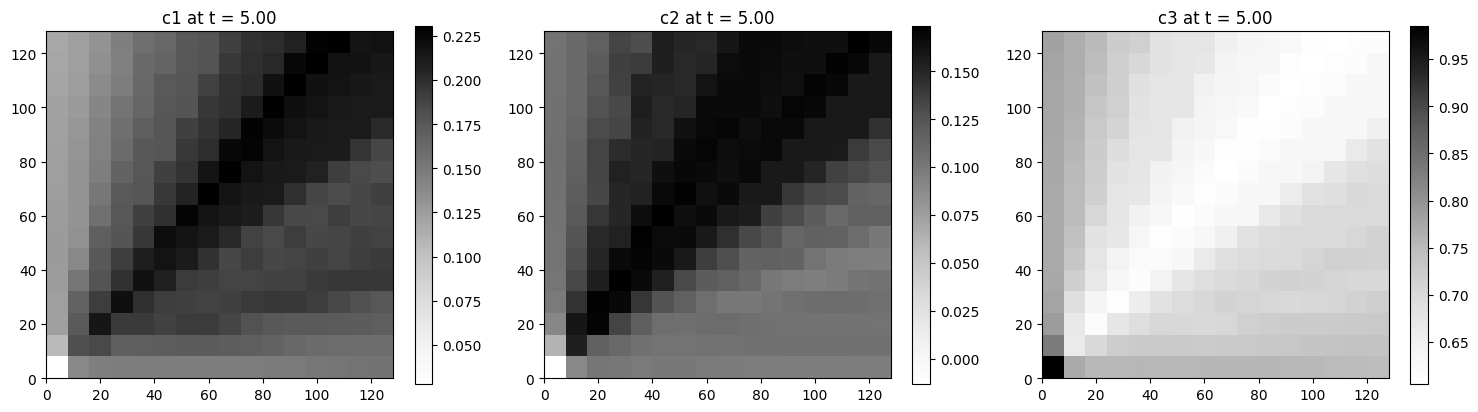

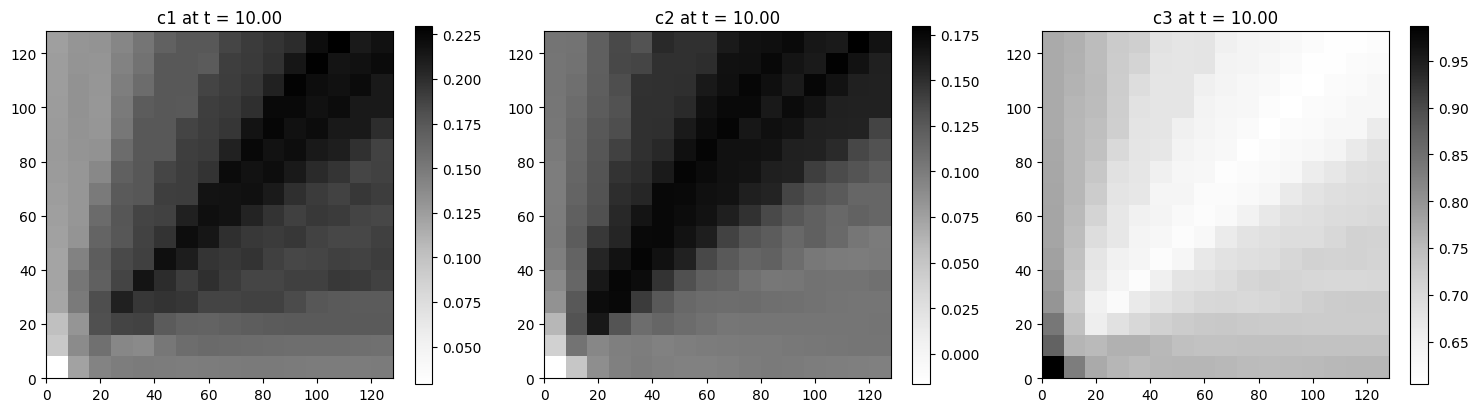

Epoch 50: Loss = 6.0146e-01


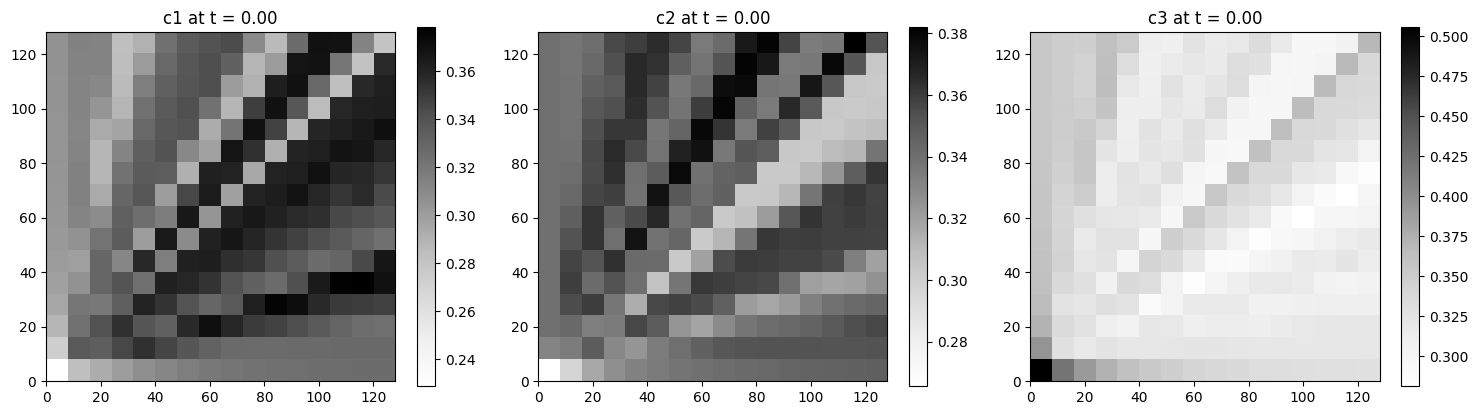

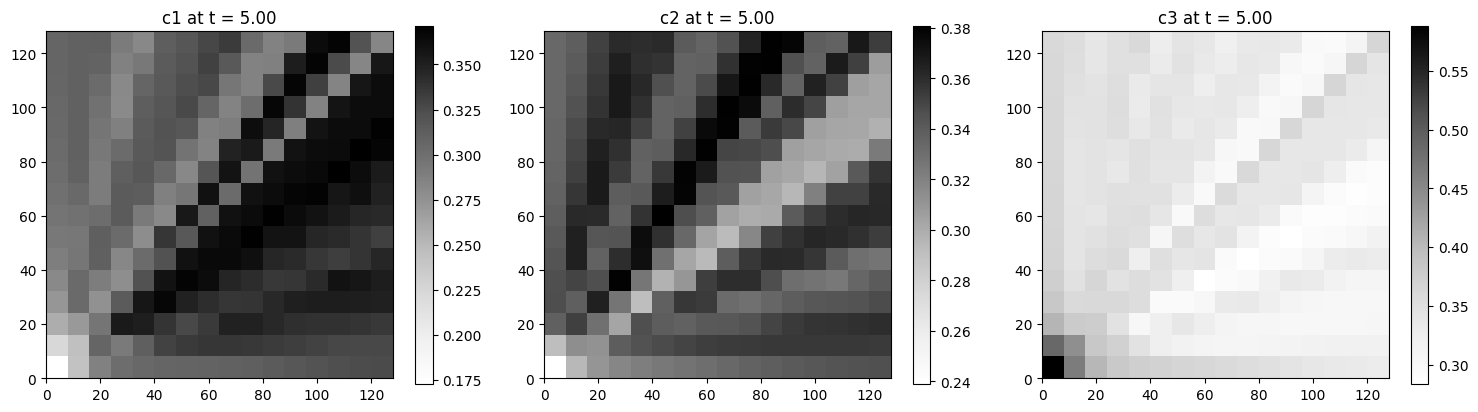

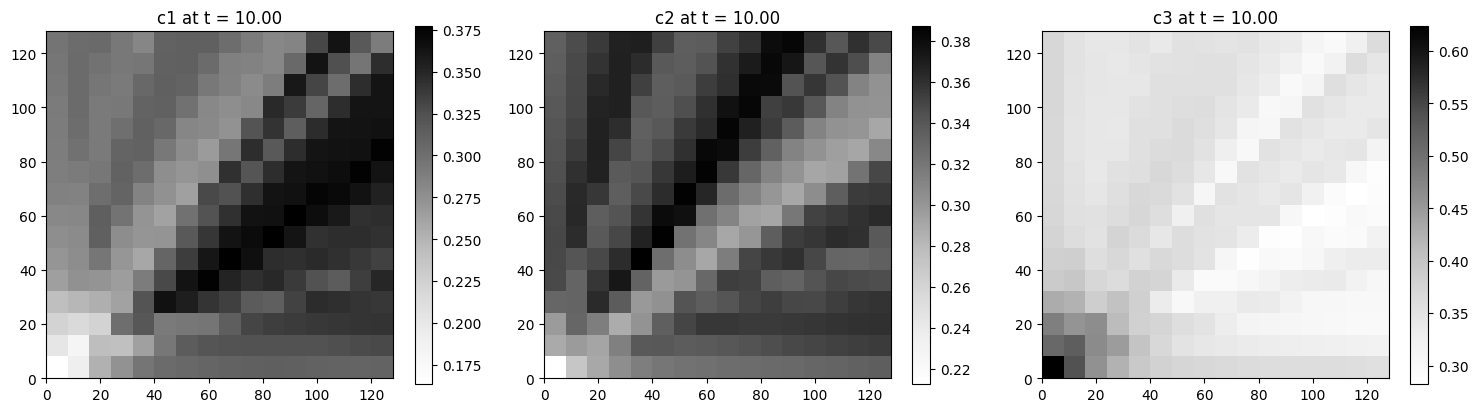

Epoch 100: Loss = 5.3124e-01


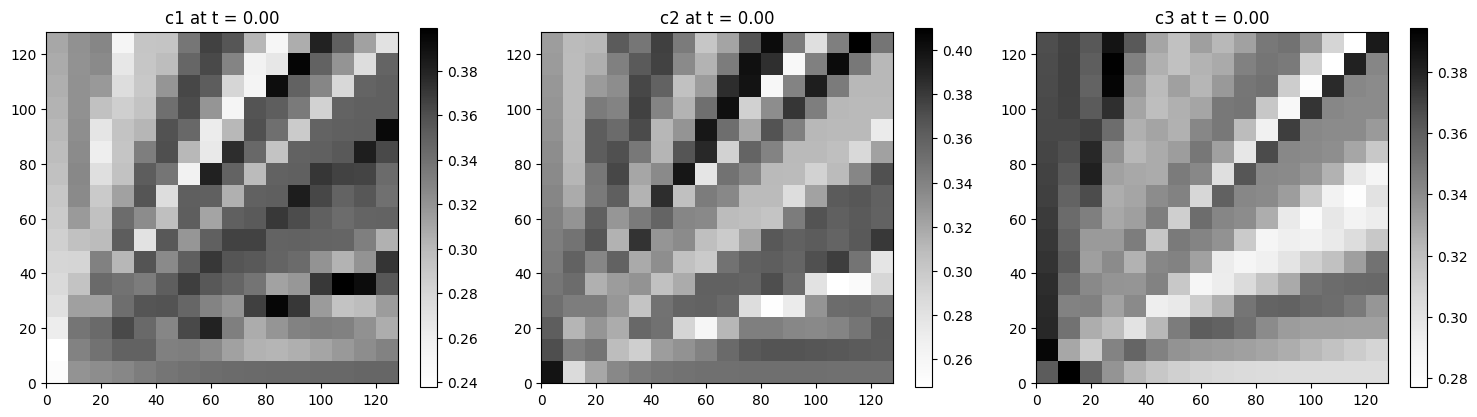

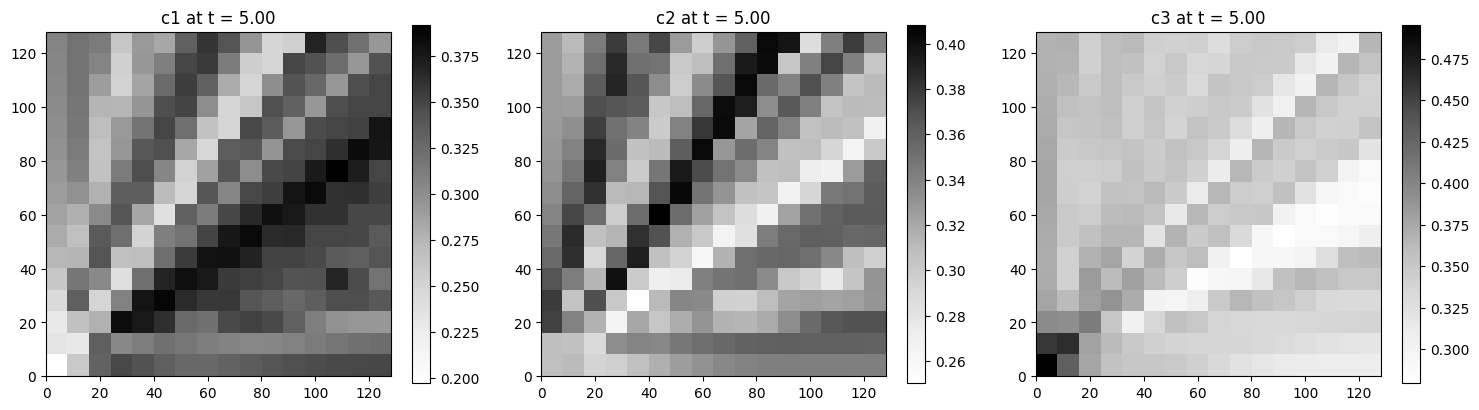

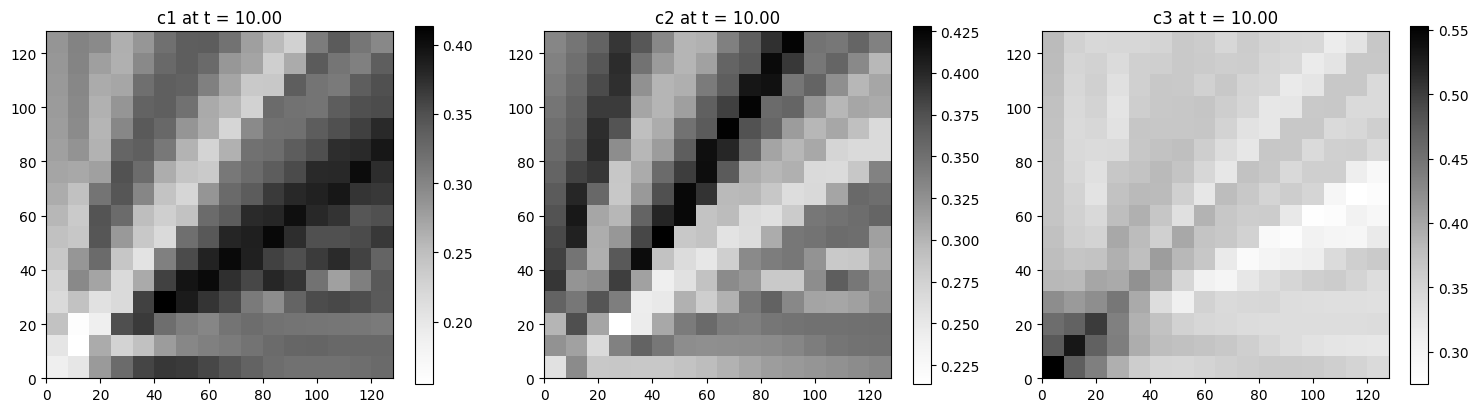

In [38]:
for epoch in range(101):
    optimizer.zero_grad()
    loss = pinn_loss(model, coords, t_vals,  Xmin, Xmax, Ymin, Ymax, Tmin, Tmax, M, coords_0, c1_0, c2_0, gamma, coords_per_bc, t_per_bc)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4e}")
        plot_slices(model, device, times, Xmin, Xmax, Ymin, Ymax, Nx=Nx, Ny=Ny)